# Gaussian Mixture Models - PCA Dataset

In [2]:
!pip install pyclustertend

## Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from sklearn.manifold import TSNE
import plotly.express as px

## Load Dataset

In [4]:
pca_df = pd.read_csv('Data/pca_dataset.csv')
pca_df.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15'],
      dtype='object')

### Metrics Calculation

c:\Users\varsh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\varsh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\varsh\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\varsh\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\varsh\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

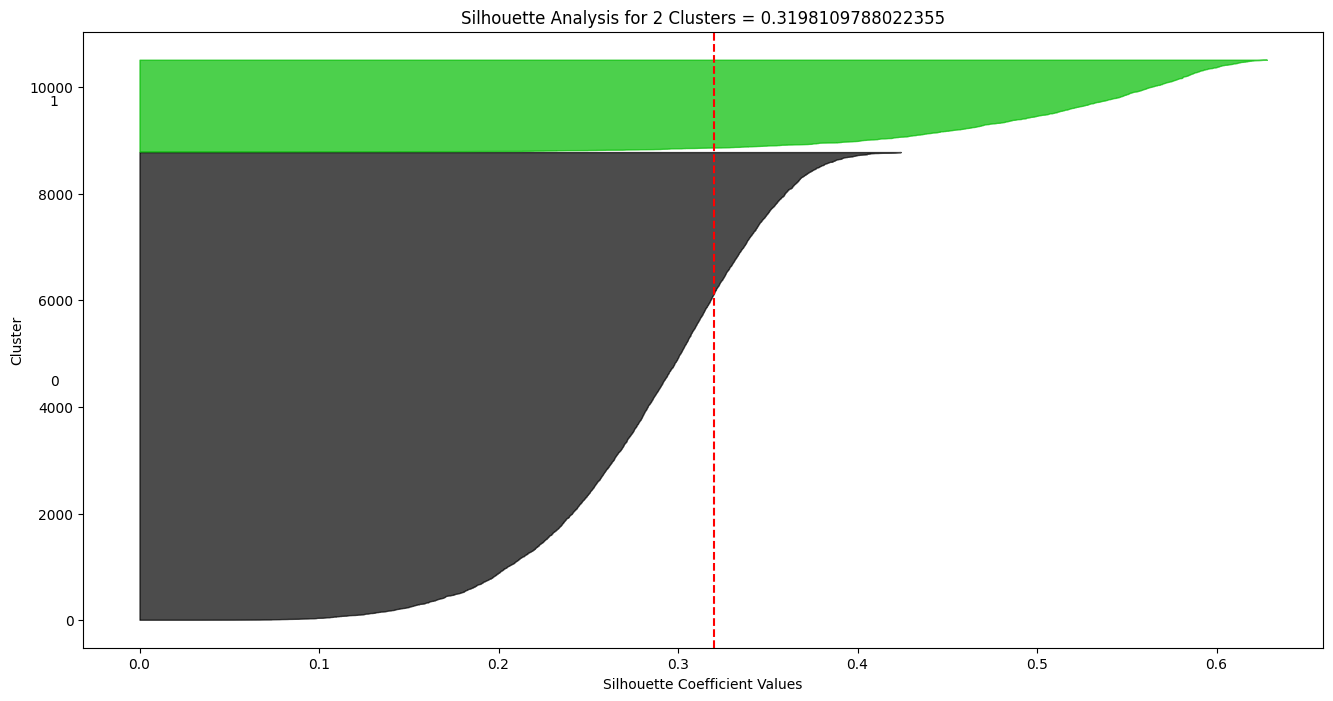

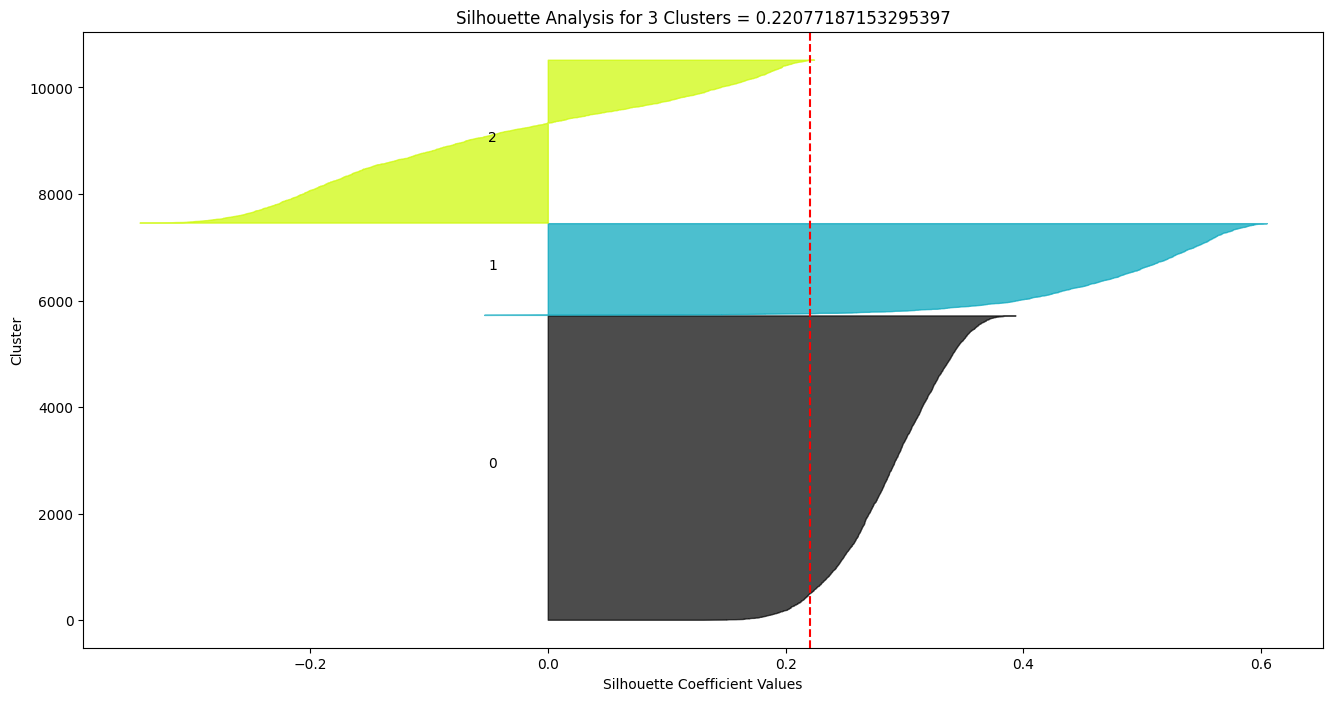

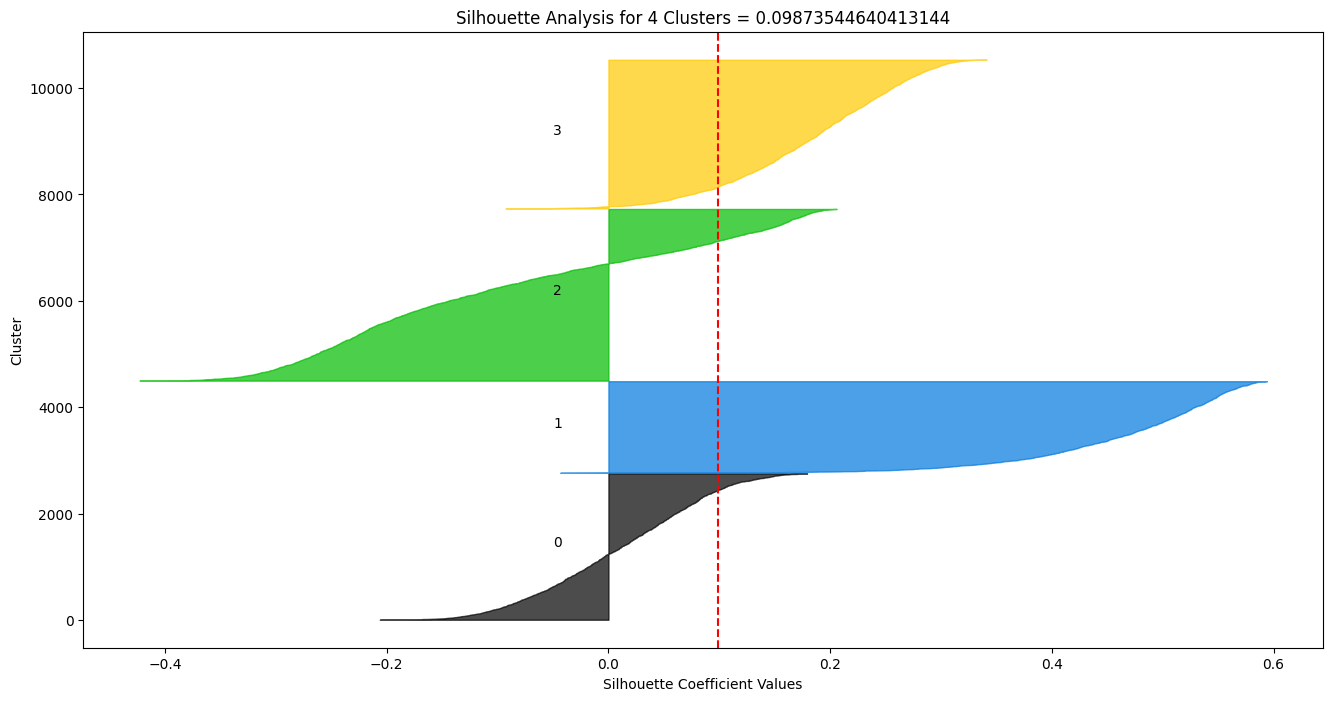

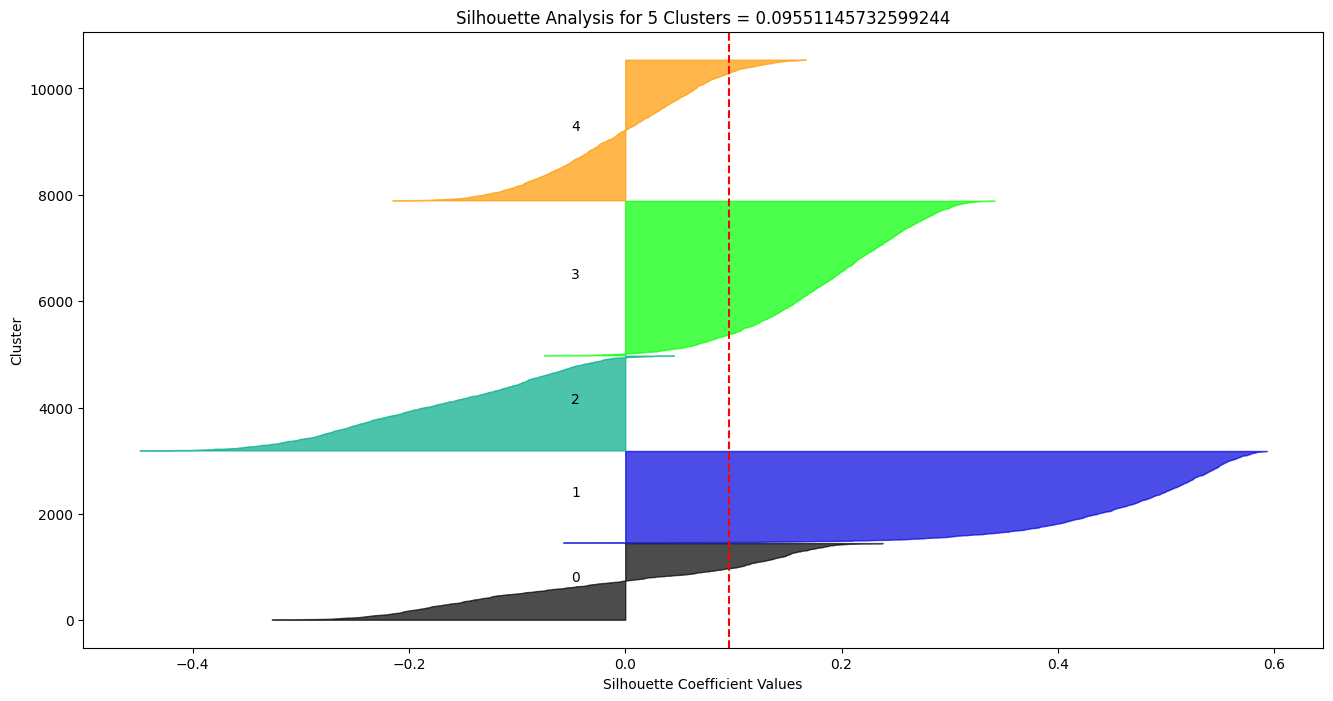

In [5]:
# Range of clusters to evaluate
range_clusters = range(2, 6)

# Initialize lists to store evaluation metrics
aic = []
bic = []
silhouette_scores = []
log_likelihood_values = []
CH_index = []
DB_values = []


silhouette_metrics = {
    "Number of Clusters": [],
    "Silhouette Score": [],
    "Log-likelihood":[],
    "CH indices":[],
    "Bic (find low)":[],
    "Davies Bouldin (find low)":[]
}

# Loop through each cluster count
for n_clusters in range_clusters:
    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_gmm = gmm.fit(pca_df)

    # 1. Calculate log-likelihood
    log_likelihood = cluster_gmm.score(pca_df) * len(pca_df)
    log_likelihood_values.append(log_likelihood)

    # 2. Calculate AIC/BIC
    aic.append(cluster_gmm.aic(pca_df))
    bic.append(cluster_gmm.bic(pca_df))

    # Assign clusters
    cluster_labels = cluster_gmm.predict(pca_df)
    #pca_df['Cluster'] = cluster_labels
    
    # 3. Calculate silhouette scores
    overall_silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(overall_silhouette_avg)
    
    # 4. Calculate CH index
    calinski_harabasz = calinski_harabasz_score(pca_df, cluster_labels)
    CH_index.append(calinski_harabasz)

    # 5. Calculate DB 
    davies_bouldin = davies_bouldin_score(pca_df, cluster_labels)
    DB_values.append(davies_bouldin)

    silhouette_metrics["Number of Clusters"].append(n_clusters)
    silhouette_metrics["Silhouette Score"].append(overall_silhouette_avg)
    silhouette_metrics["Log-likelihood"].append(log_likelihood)
    silhouette_metrics["CH indices"].append(calinski_harabasz)
    silhouette_metrics["Bic (find low)"].append(cluster_gmm.bic(pca_df))
    silhouette_metrics["Davies Bouldin (find low)"].append(davies_bouldin)


    # Visualize silhouette plot
    silhouette_per_sample = silhouette_samples(pca_df, cluster_labels)

    plt.figure(figsize=(16, 8))
    y_lower = 10
    for i in range(n_clusters):
        
        cluster_values = silhouette_per_sample[np.array(cluster_labels) == i]
        cluster_values.sort()

        size_cluster = cluster_values.shape[0]
        y_upper = y_lower + size_cluster
        color = plt.cm.nipy_spectral(float(i) / n_clusters)

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=overall_silhouette_avg, color="red", linestyle="--")
    plt.title(f"Silhouette Analysis for {n_clusters} Clusters = {overall_silhouette_avg}")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")
    plt.show()


metrics_df = pd.DataFrame(silhouette_metrics)

In [6]:
print(metrics_df)

   Number of Clusters  Silhouette Score  Log-likelihood   CH indices  \
0                   2          0.319811  -220771.904858  3187.871531   
1                   3          0.220772  -200379.528517  2548.426833   
2                   4          0.098735  -196515.975288  1849.150072   
3                   5          0.095511  -194457.828417  1455.900292   

   Bic (find low)  Davies Bouldin (find low)  
0   444052.827536                   1.103888  
1   404527.212949                   1.973236  
2   398059.244584                   2.356608  
3   395202.088937                   3.377187  


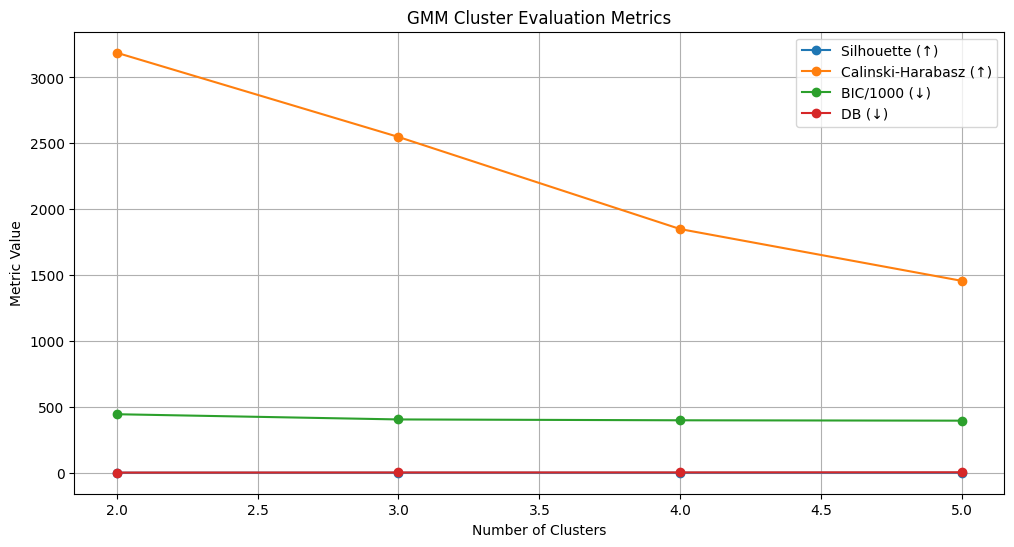

In [7]:
plt.figure(figsize=(12,6))
plt.plot(metrics_df["Number of Clusters"], metrics_df["Silhouette Score"], marker='o', label="Silhouette (↑)")
plt.plot(metrics_df["Number of Clusters"], metrics_df["CH indices"], marker='o', label="Calinski-Harabasz (↑)")
plt.plot(metrics_df["Number of Clusters"], metrics_df["Bic (find low)"]/1000, marker='o', label="BIC/1000 (↓)")
plt.plot(metrics_df["Number of Clusters"], metrics_df["Davies Bouldin (find low)"], marker='o', label="DB (↓)")

plt.title("GMM Cluster Evaluation Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()


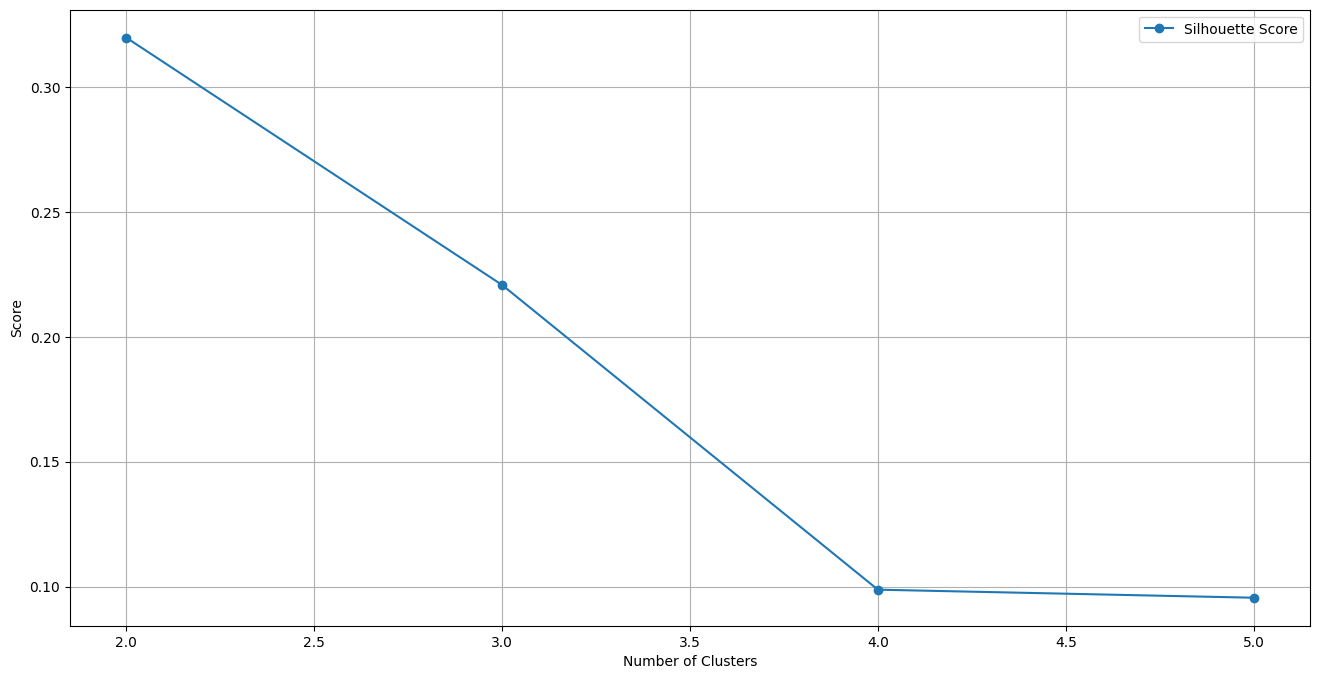

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(range_clusters, silhouette_scores, marker='o', label="Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

### 3D Visualization


Processing for 2 clusters...

Processing for 3 clusters...

Processing for 4 clusters...

Processing for 5 clusters...


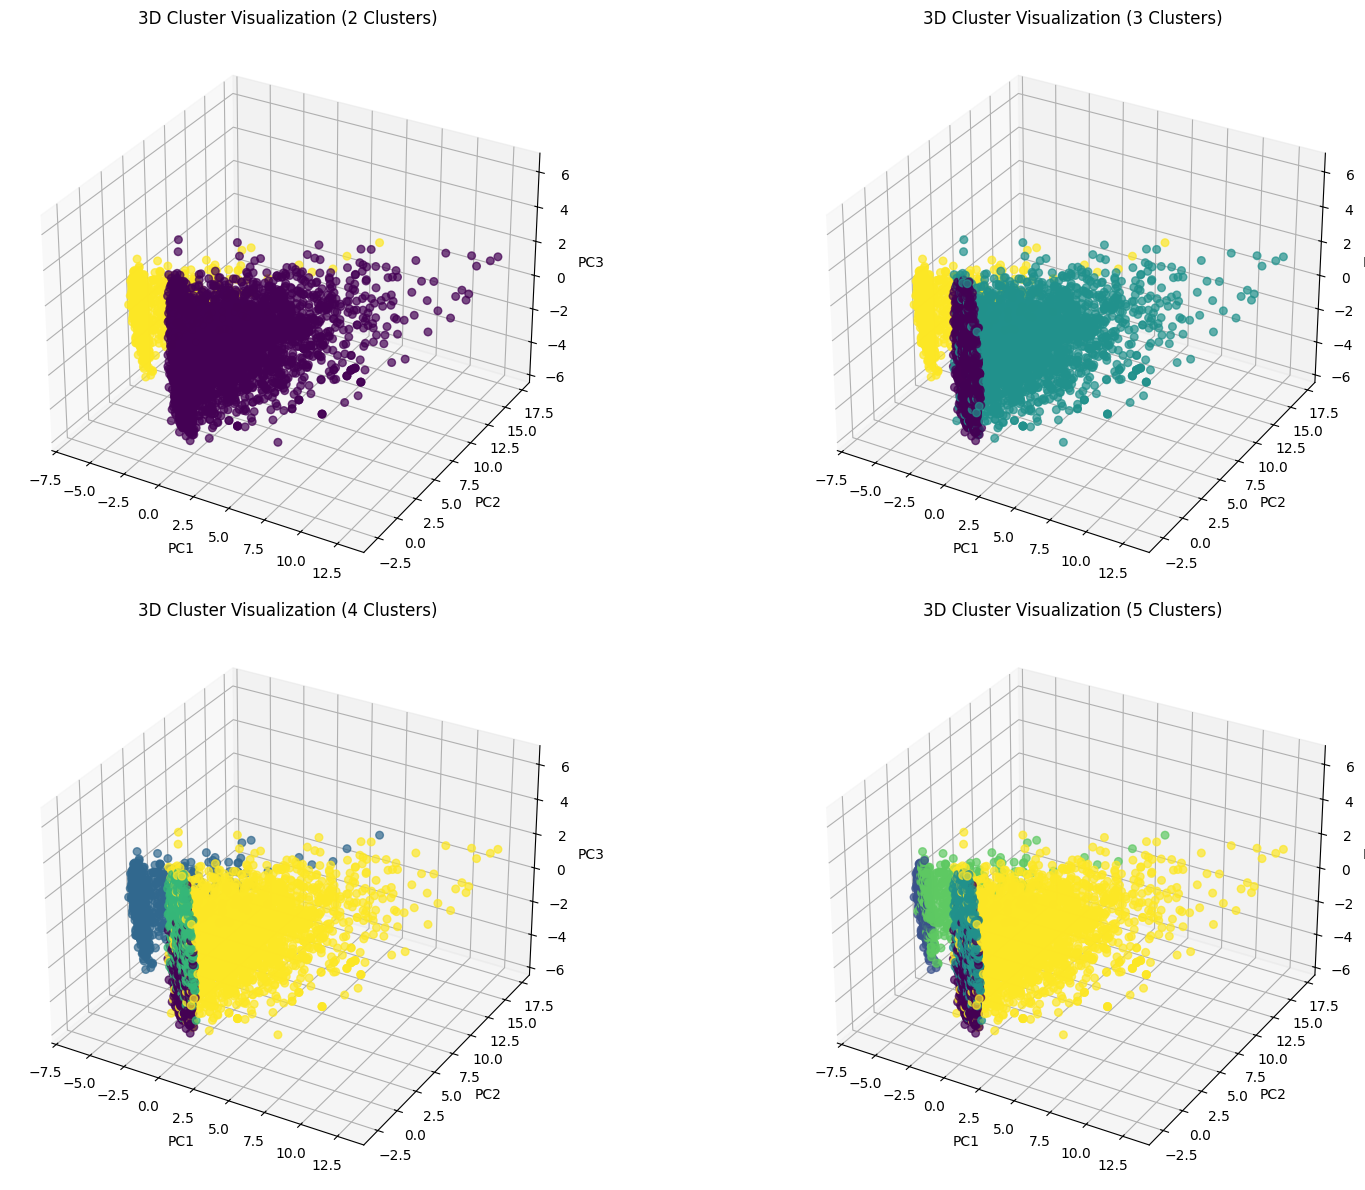

In [9]:
# Define range for clusters (2 to 5)
cluster_range = range(2, 6)

fig = plt.figure(figsize=(18, 12))

for idx, n_clusters in enumerate(cluster_range):
    print(f"\nProcessing for {n_clusters} clusters...")

    # Fit GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    pca_df['Cluster'] = gmm.fit_predict(pca_df)

    # Create 3D subplot
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')

    # Scatter plot using first 3 PCA components
    scatter = ax.scatter(
        pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
        c=pca_df['Cluster'], cmap='viridis', s=30, alpha=0.7
    )

    ax.set_title(f'3D Cluster Visualization ({n_clusters} Clusters)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()

### TSNE Visualization

Running GMM + t-SNE for 2 clusters...
Running GMM + t-SNE for 3 clusters...
Running GMM + t-SNE for 4 clusters...
Running GMM + t-SNE for 5 clusters...


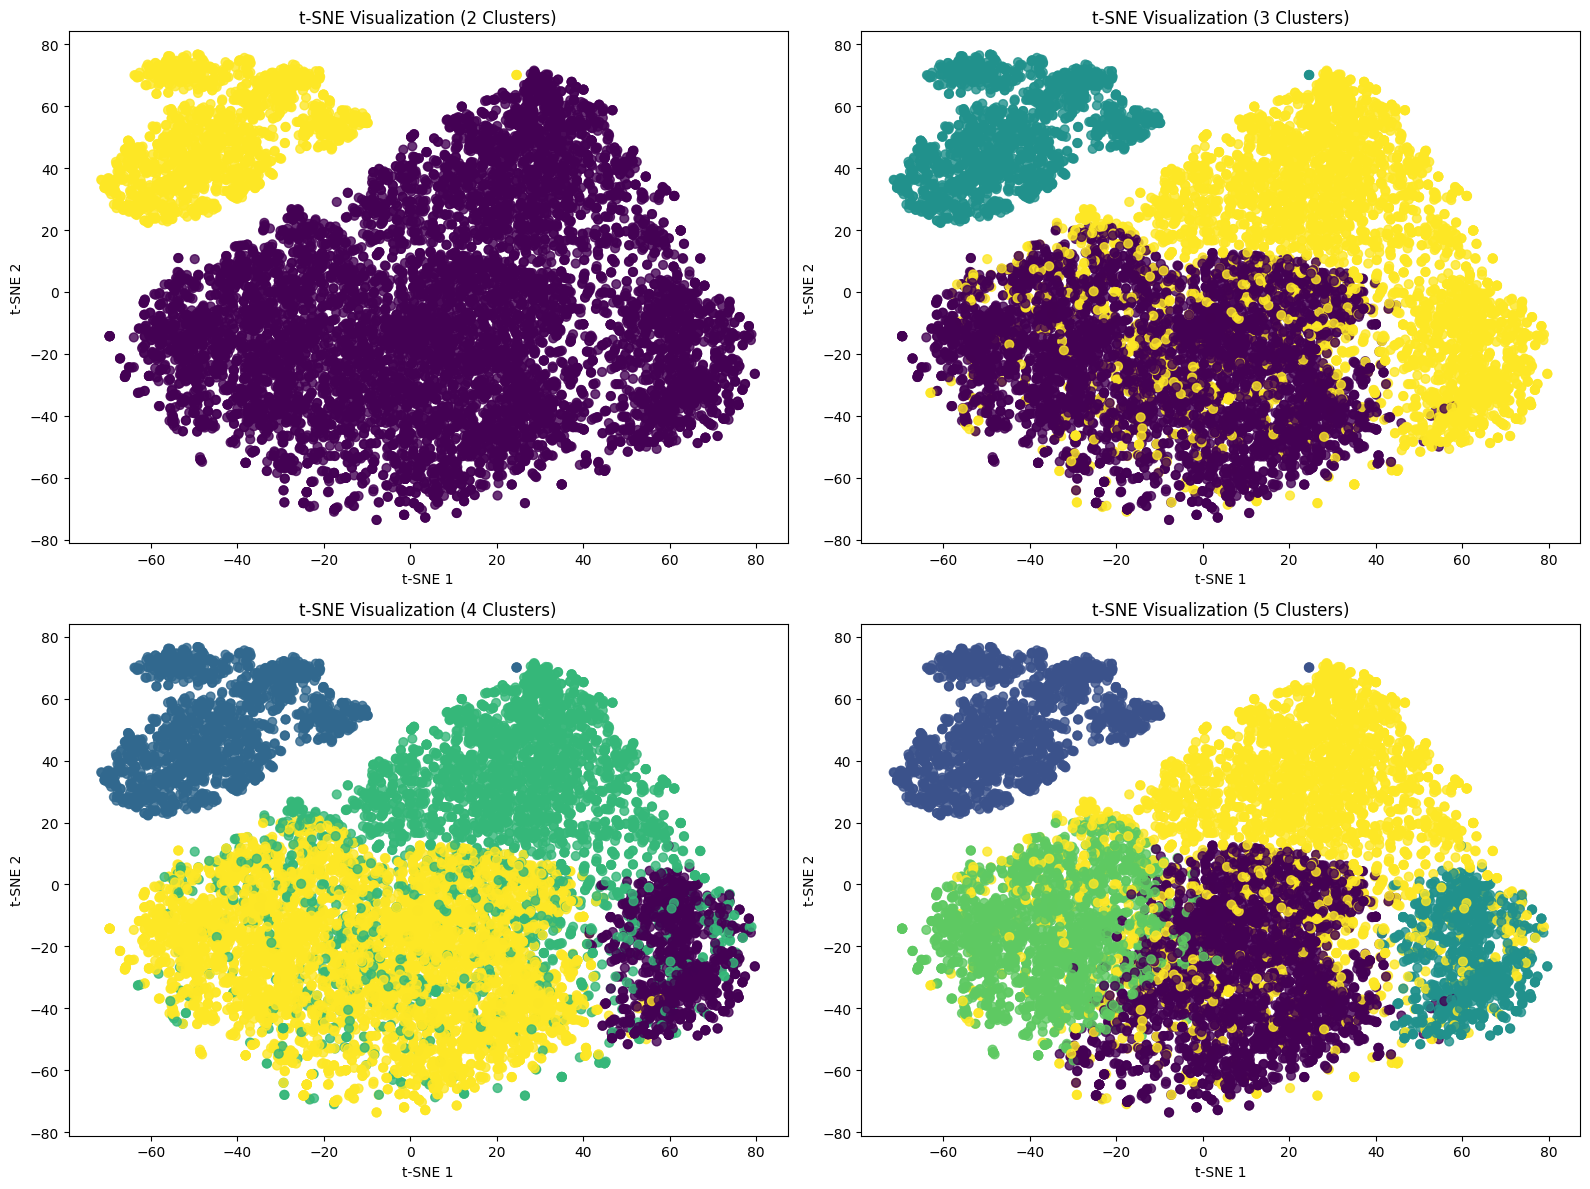

In [10]:
# Define range for clusters (2 to 5)
cluster_range = range(2, 6)

# Create figure for all subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, n_clusters in enumerate(cluster_range):
    print(f"Running GMM + t-SNE for {n_clusters} clusters...")

    # Step 1: Fit GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    pca_df['Cluster'] = gmm.fit_predict(pca_df)

    # Step 2: Run t-SNE (2D projection)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    tsne_result = tsne.fit_transform(pca_df[[f'PC{i}' for i in range(1, 16)]])

    # Step 3: Add TSNE coordinates
    pca_df['TSNE1'] = tsne_result[:, 0]
    pca_df['TSNE2'] = tsne_result[:, 1]

    # Step 4: Plot t-SNE scatter
    ax = axes[idx // 2, idx % 2]
    scatter = ax.scatter(
        pca_df['TSNE1'], pca_df['TSNE2'],
        c=pca_df['Cluster'], cmap='viridis', s=40, alpha=0.8
    )
    ax.set_title(f"t-SNE Visualization ({n_clusters} Clusters)")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()


## Summary

✅ Final model fitted with 3 clusters.

Cluster Size Distribution:
Final_Cluster
0    4740
1    1722
2    4030
Name: count, dtype: int64




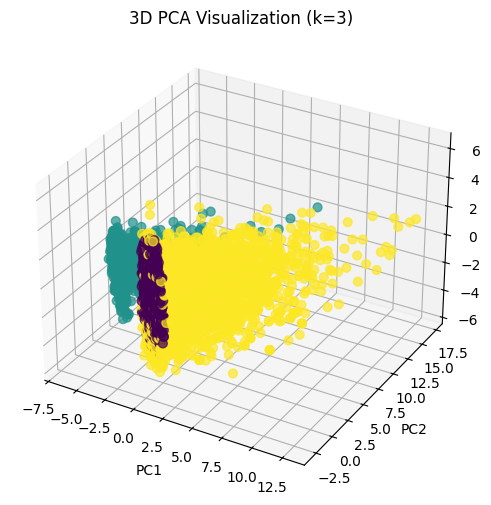

In [11]:
# ==========================================
# 📊 FINAL GMM CLUSTER SUMMARY & VISUALIZATION
# ==========================================

# --- Pick the best number of clusters based on metrics ---
best_n = 3   # Replace with the optimal number determined from previous analysis

# Fit final GMM model
final_gmm = GaussianMixture(n_components=best_n, random_state=42)
pca_df['Final_Cluster'] = final_gmm.fit_predict(pca_df)

print(f"✅ Final model fitted with {best_n} clusters.\n")

# --- 2️Cluster Size Summary ---
cluster_counts = pca_df['Final_Cluster'].value_counts().sort_index()
print("Cluster Size Distribution:")
print(cluster_counts)
print("\n")

# --- 3D PCA Visualization (optional) ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
    c=pca_df['Final_Cluster'], cmap='viridis', s=40, alpha=0.7
)
ax.set_title(f'3D PCA Visualization (k={best_n})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()




## Subclustering for clusters 0 and 2


 Subclustering analysis for parent cluster: 0
Subset size: 4740 samples

  Fitting GMM with n_sub = 2 ...


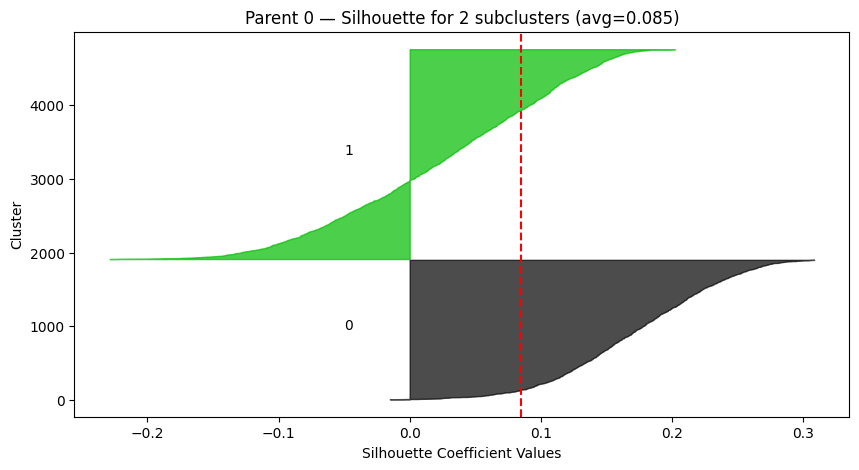


  Fitting GMM with n_sub = 3 ...


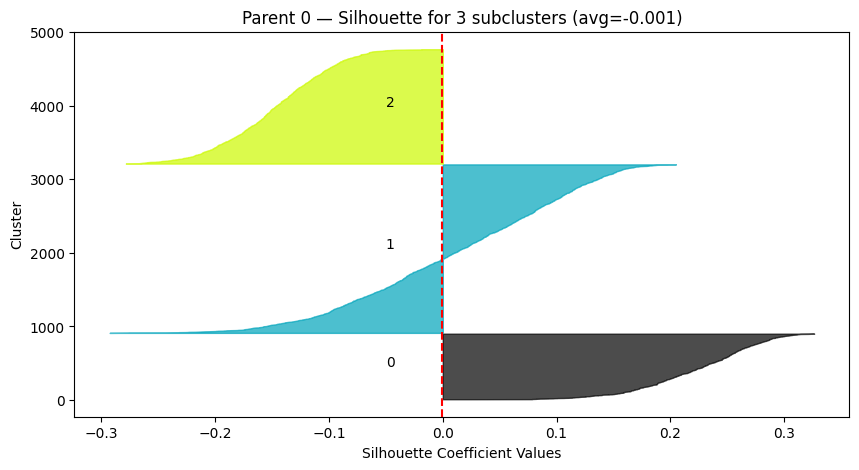


  Fitting GMM with n_sub = 4 ...


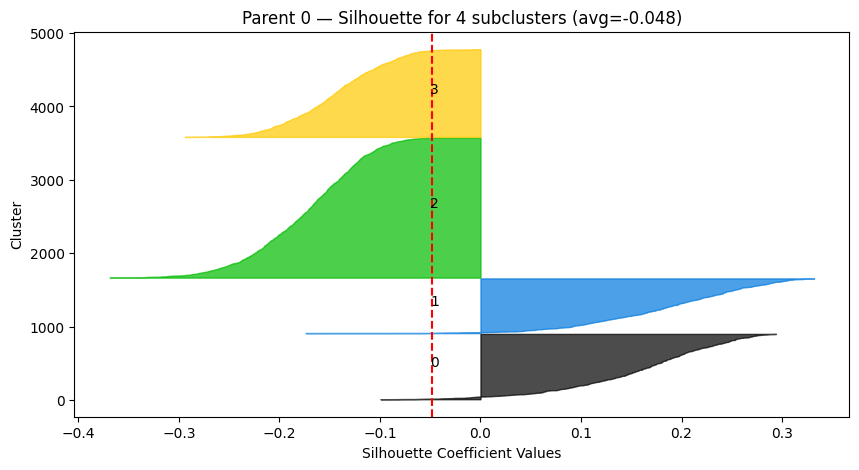


  Fitting GMM with n_sub = 5 ...


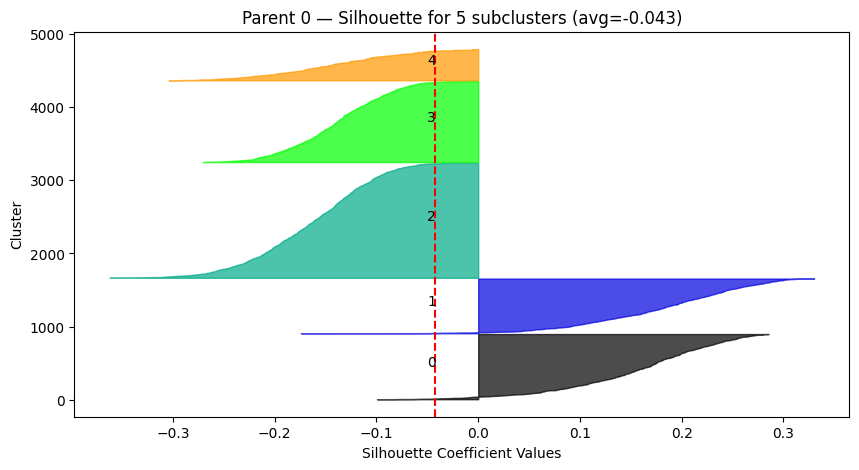


Summary metrics for parent cluster 0


Number of Subclusters  Silhouette Score  Log-likelihood  CH indices  \
0                      2          0.085229   -71740.281521  461.732940   
1                      3         -0.000802   -65189.005534  275.692491   
2                      4         -0.048070   -57619.920911  158.748152   
3                      5         -0.042649   -57023.944665  141.775234   

   BIC (find low)  Davies Bouldin (find low)            AIC  
0   145774.250786                   2.951170  144022.563042  
1   133822.774581                   8.841292  131192.011069  
2   119835.681104                   8.541242  116325.841822  
3   119794.804380                   7.314842  115405.889330


 Subclustering analysis for parent cluster: 2
Subset size: 4030 samples

  Fitting GMM with n_sub = 2 ...


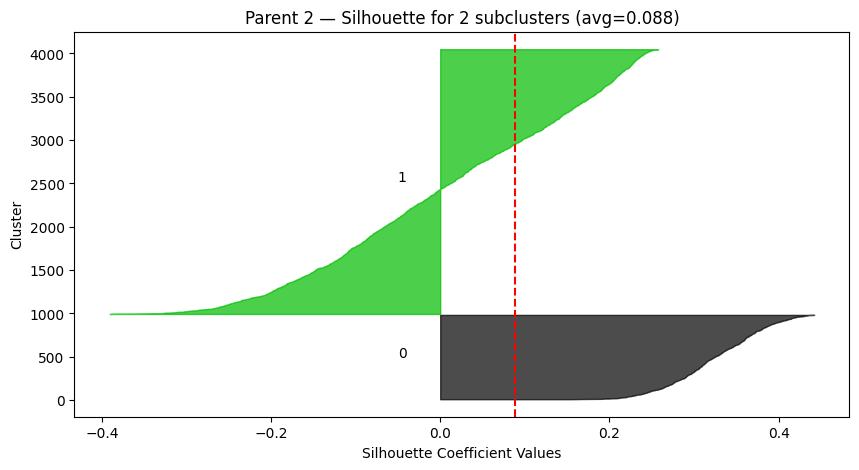


  Fitting GMM with n_sub = 3 ...


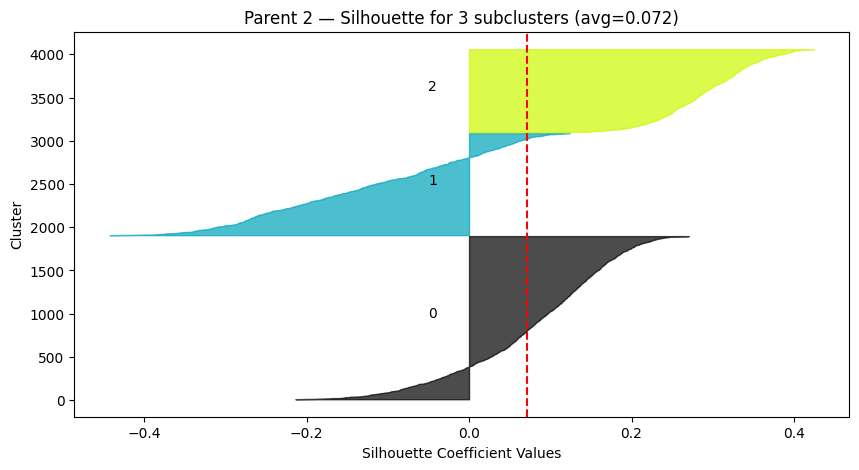


  Fitting GMM with n_sub = 4 ...


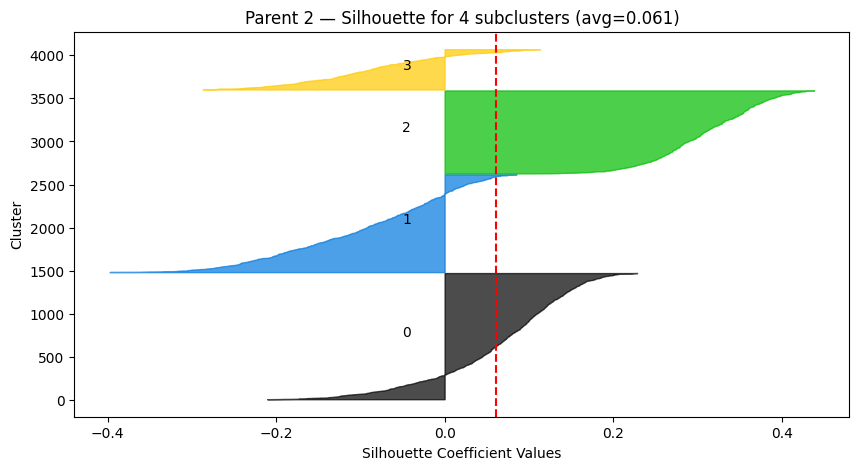


  Fitting GMM with n_sub = 5 ...


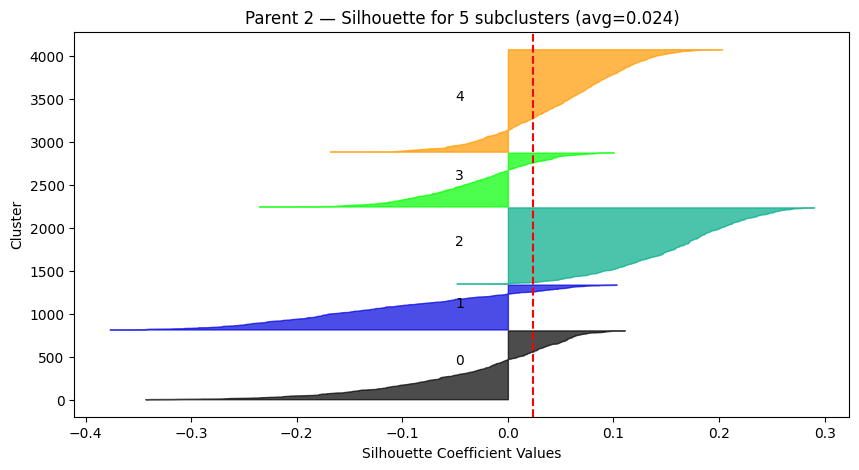


Summary metrics for parent cluster 2


Number of Subclusters  Silhouette Score  Log-likelihood  CH indices  \
0                      2          0.087991   -88099.998190  547.907542   
1                      3          0.071535   -86342.032418  398.883102   
2                      4          0.060885   -85295.092347  290.094852   
3                      5          0.023608   -84641.758379  285.222551   

   BIC (find low)  Davies Bouldin (find low)            AIC  
0   178449.708749                   1.999902  176741.996381  
1   176062.784149                   3.104659  173498.064836  
2   175097.910953                   3.538962  171676.184694  
3   174920.249962                   3.811207  170641.516758

In [12]:
# Subcluster evaluation for two large PCA clusters (0 and 2)
# parent clusters to examine
parent_clusters = [0, 2]

# features to use (PC1..PC15)
pc_cols = [f"PC{i}" for i in range(1, 16)]

results_by_parent = {}

for parent in parent_clusters:
    print("\n" + "="*60)
    print(f" Subclustering analysis for parent cluster: {parent}")
    print("="*60)

    subset_idx = pca_df[pca_df['Final_Cluster'] == parent].index
    subset = pca_df.loc[subset_idx, pc_cols].copy()
    n_samples = subset.shape[0]
    print(f"Subset size: {n_samples} samples")

    if n_samples < 4:
        print(f"Too few samples ({n_samples}) to meaningfully subcluster. Skipping.")
        continue

    range_clusters = range(2, 6)  # 2..5 subclusters
    metrics = {
        "Number of Subclusters": [],
        "Silhouette Score": [],
        "Log-likelihood": [],
        "CH indices": [],
        "BIC (find low)": [],
        "Davies Bouldin (find low)": [],
        "AIC": []
    }

    for n_sub in range_clusters:
        # skip if trying to create more clusters than samples
        if n_sub >= n_samples:
            print(f"  Skipping n={n_sub} (n_sub >= n_samples)")
            continue

        print(f"\n  Fitting GMM with n_sub = {n_sub} ...")
        gmm = GaussianMixture(n_components=n_sub, random_state=42)
        gmm.fit(subset)

        # labels
        labels = gmm.predict(subset)

        # log-likelihood (total)
        log_likelihood = gmm.score(subset) * subset.shape[0]

        # AIC / BIC
        aic = gmm.aic(subset)
        bic = gmm.bic(subset)

        # silhouette (only valid if >1 cluster present and each cluster has >1 sample)
        valid_silhouette = True
        try:
            sil = silhouette_score(subset, labels)
        except Exception as e:
            sil = np.nan
            valid_silhouette = False
            print(f"    silhouette_score failed: {e}")

        # CH index (needs >1 cluster)
        try:
            ch = calinski_harabasz_score(subset, labels)
        except Exception as e:
            ch = np.nan

        # Davies-Bouldin (needs >1 cluster)
        try:
            db = davies_bouldin_score(subset, labels)
        except Exception as e:
            db = np.nan

        # store metrics
        metrics["Number of Subclusters"].append(n_sub)
        metrics["Silhouette Score"].append(sil)
        metrics["Log-likelihood"].append(log_likelihood)
        metrics["CH indices"].append(ch)
        metrics["BIC (find low)"].append(bic)
        metrics["Davies Bouldin (find low)"].append(db)
        metrics["AIC"].append(aic)

        # --- Silhouette plot (per-sample) ---
        if valid_silhouette:
            sil_vals = silhouette_samples(subset, labels)
            plt.figure(figsize=(10, 5))
            y_lower = 10
            for i in range(n_sub):
                ith_cluster_sil_vals = sil_vals[labels == i]
                ith_cluster_sil_vals.sort()
                size_cluster_i = ith_cluster_sil_vals.shape[0]
                y_upper = y_lower + size_cluster_i
                color = plt.cm.nipy_spectral(float(i) / n_sub)
                plt.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_sil_vals,
                                  facecolor=color, edgecolor=color, alpha=0.7)
                plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            plt.axvline(x=sil, color="red", linestyle="--")
            plt.title(f"Parent {parent} — Silhouette for {n_sub} subclusters (avg={sil:.3f})")
            plt.xlabel("Silhouette Coefficient Values")
            plt.ylabel("Cluster")
            plt.show()
        else:
            print("    Skipping silhouette plot (invalid).")

    # assemble metrics dataframe for this parent cluster
    metrics_df = pd.DataFrame(metrics)
    results_by_parent[parent] = metrics_df
    print("\nSummary metrics for parent cluster", parent)
    display(metrics_df)


## 3D Visualization for Main + Subclusters

In [13]:
# Columns for PCA space
pc_cols = [f"PC{i}" for i in range(1, 4)]  # first 3 PCs for visualization

# Make a copy
pca_combined = pca_df.copy()

# Initialize new column
pca_combined["Combined_Cluster"] = pca_combined["Final_Cluster"].astype(str)

# --- Split cluster 0 into 2 subclusters ---
for main_cluster in [0, 2]:
    mask = pca_combined["Final_Cluster"] == main_cluster
    sub_df = pca_combined.loc[mask, pc_cols]

    gmm_sub = GaussianMixture(n_components=2, random_state=42)
    sub_labels = gmm_sub.fit_predict(sub_df)

    # Assign new combined labels (e.g., "0.0" and "0.1")
    pca_combined.loc[mask, "Combined_Cluster"] = [
        f"{main_cluster}.{sub}" for sub in sub_labels
    ]

# Convert to string type (for plotting)
pca_combined["Combined_Cluster"] = pca_combined["Combined_Cluster"].astype(str)

# --- 🎨 3D Visualization ---
fig = px.scatter_3d(
    pca_combined,
    x="PC1", y="PC2", z="PC3",
    color="Combined_Cluster",
    title="3D PCA Visualization — Main Clusters + Subclusters",
    opacity=0.8,
    color_discrete_sequence=px.colors.qualitative.Safe,
    hover_data=["Final_Cluster"]
)

fig.update_traces(marker=dict(size=4, line=dict(width=0)))
fig.update_layout(scene=dict(
    xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3",
))
fig.show()

# --- 🧾 Optional: check new distribution
print("Cluster size distribution after subclustering:")
print(pca_combined["Combined_Cluster"].value_counts().sort_index())


c:\Users\varsh\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


Cluster size distribution after subclustering:
Combined_Cluster
0.0    2381
0.1    2359
1      1722
2.0    1144
2.1    2886
Name: count, dtype: int64


In [14]:
# Make a copy to avoid overwriting original clusters
subcluster_df = pca_df.copy()

# Initialize Subcluster column
subcluster_df['Subcluster'] = np.nan

# Function to subcluster a given cluster
def subcluster_main(cluster_label, n_subclusters):
    cluster_mask = subcluster_df['Final_Cluster'] == cluster_label
    cluster_data = subcluster_df.loc[cluster_mask, ['PC1', 'PC2', 'PC3']]  # or UMAP1-3
    gmm = GaussianMixture(n_components=n_subclusters, random_state=42)
    sub_labels = gmm.fit_predict(cluster_data)
    subcluster_df.loc[cluster_mask, 'Subcluster'] = sub_labels

# Subcluster Cluster 0 into 3 subclusters
subcluster_main(0, 3)

# Subcluster Cluster 2 into 3 subclusters
subcluster_main(2, 3)

# Create combined labels for visualization
subcluster_df['Combined_Cluster'] = subcluster_df['Final_Cluster'].astype(str)

# Update combined labels for subclusters
for main_cluster in [0, 2]:
    mask = subcluster_df['Final_Cluster'] == main_cluster
    subcluster_df.loc[mask, 'Combined_Cluster'] = (
        subcluster_df.loc[mask, 'Final_Cluster'].astype(str) + '.' + subcluster_df.loc[mask, 'Subcluster'].astype(int).astype(str)
    )

# Check distribution
print(subcluster_df['Combined_Cluster'].value_counts().sort_index())


Combined_Cluster
0.0    1336
0.1    2091
0.2    1313
1      1722
2.0    1882
2.1    1016
2.2    1132
Name: count, dtype: int64


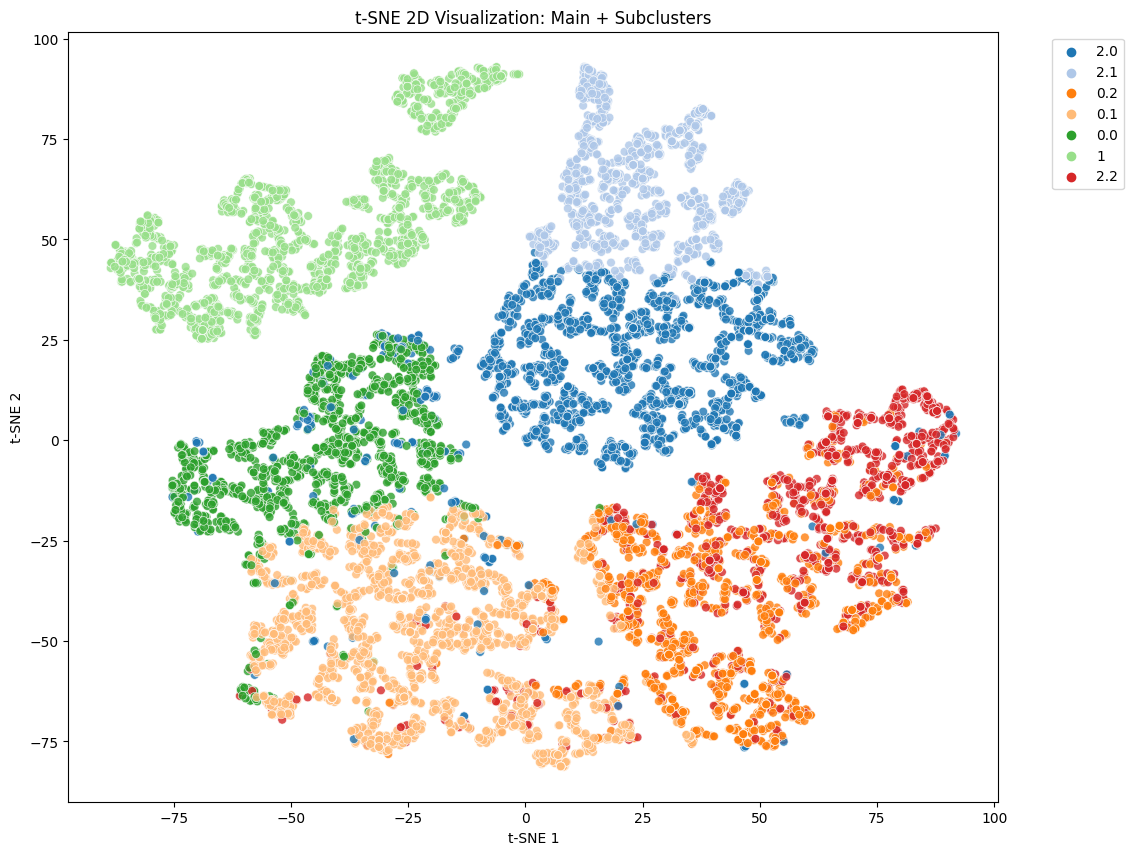

In [15]:
# Select only the features to use for t-SNE (PCA or UMAP components)
features = subcluster_df[['PC1', 'PC2', 'PC3']].values

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
subcluster_df['TSNE1'] = tsne_result[:, 0]
subcluster_df['TSNE2'] = tsne_result[:, 1]

# Plot t-SNE scatter
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=subcluster_df,
    x='TSNE1', y='TSNE2',
    hue='Combined_Cluster',
    palette='tab20',
    s=40,
    alpha=0.8
)
plt.title("t-SNE 2D Visualization: Main + Subclusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [29]:
subcluster_df.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'Cluster', 'TSNE1', 'TSNE2',
       'Final_Cluster', 'Subcluster', 'Combined_Cluster'],
      dtype='object')

## Final Cluster Percentages

In [31]:
# --- Main Cluster Percentages ---
main_cluster_pct = (
    subcluster_df['Final_Cluster']
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(2)
)

print("📊 Percentage of Samples in Each Main Cluster:")
print(main_cluster_pct)

# --- Subcluster Percentages ---
subcluster_pct = (
    subcluster_df['Combined_Cluster']
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(2)
)

print("\n📊 Percentage of Samples in Each Subcluster:")
print(subcluster_pct)


📊 Percentage of Samples in Each Main Cluster:
Final_Cluster
0    45.18
1    16.41
2    38.41
Name: proportion, dtype: float64

📊 Percentage of Samples in Each Subcluster:
Combined_Cluster
0.0    12.73
0.1    19.93
0.2    12.51
1      16.41
2.0    17.94
2.1     9.68
2.2    10.79
Name: proportion, dtype: float64
